In [15]:
import os
import re
import sys

import h5py
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks')

#SED Variant Scoring functions below

#Function to read eQTL dataframe (storing scores at SNP-gene level)
def read_eqtl_sed(tissue, gtex_vcf_dir, pip_t=0.9):
    """Reads eQTLs from SUSIE output.
    
    Args:
        tissue (str): Tissue name.
        gtex_vcf_dir (str): GTEx VCF directory.
        pip_t (float): PIP threshold.

    Returns:
        eqtl_df (pd.DataFrame): eQTL dataframe, or None if tissue skipped.
    """
    
    susie_dir = '/home/drk/seqnn/data/gtex_fine/tissues_susie'

    #Read causal variants
    eqtl_file = f'{susie_dir}/{tissue}.tsv'
    df_eqtl = pd.read_csv(eqtl_file, sep='\t', index_col=0)

    #PIP filter
    pip_match = re.search(r"_pip(\d+).?$", gtex_vcf_dir).group(1)
    
    pip_t = float(pip_match) / 100
    assert(pip_t > 0 and pip_t <= 1)
    
    df_causal = df_eqtl[df_eqtl.pip > pip_t]
    
    #Make table
    tissue_vcf_file = f'{gtex_vcf_dir}/{tissue}_pos.vcf'
    if not os.path.isfile(tissue_vcf_file):
        eqtl_df = None
    else:
        #Create dataframe with SNP-gene coefficients
        eqtl_df = pd.DataFrame({
            'variant': df_causal.variant,
            'gene': [trim_dot(gene_id) for gene_id in df_causal.gene],
            'coef': df_causal.beta_posterior,
            'allele1': df_causal.allele1
        })
    
    return eqtl_df

#Function to remove the trailing dot from gene ids
def trim_dot(gene_id):
    """Trim dot off GENCODE id's."""
    
    dot_i = gene_id.rfind('.')
    
    #Remove dot if it was found
    if dot_i != -1:
        gene_id = gene_id[:dot_i]
    
    return gene_id

#Function to read Borzoi SED (or logSED) variant effect predictions
def read_borzoi_sed(gtex_scores_file, keyword, eqtl_df, score_key='SED', verbose=False):
    """Read eQTL RNA predictions for the given tissue.
    
    Args:
        gtex_scores_file (str): Variant scores HDF5.
        tissue_keyword (str): tissue keyword, for matching GTEx targets
        eqtl_df (pd.DataFrame): eQTL dataframe
        score_key (str): score key in HDF5 file
        verbose (bool): Print matching targets.

    Returns:
        eqtl_df (pd.DataFrame): eQTL dataframe, with added scores
    """
    
    #Read variant scores
    with h5py.File(gtex_scores_file, 'r') as gtex_scores_h5:
        
        #Extract metadata
        snp_i = gtex_scores_h5['si'][:]
        snps = np.array([snp.decode('UTF-8') for snp in gtex_scores_h5['snp']])
        ref_allele = np.array([ref.decode('UTF-8') for ref in gtex_scores_h5['ref_allele']])
        genes = np.array([snp.decode('UTF-8') for snp in gtex_scores_h5['gene']])
        target_ids = np.array([ref.decode('UTF-8') for ref in gtex_scores_h5['target_ids']])
        target_labels = np.array([ref.decode('UTF-8') for ref in gtex_scores_h5['target_labels']])
        
        #Determine matching GTEx targets
        match_tis = []
        for ti in range(len(target_ids)):
            if target_ids[ti].find('GTEX') != -1 and target_labels[ti].find(keyword) != -1:
                if not keyword == 'blood' or target_labels[ti].find('vessel') == -1:
                    if verbose:
                        print(ti, target_ids[ti], target_labels[ti])
                    match_tis.append(ti)
        match_tis = np.array(match_tis)
        
        #Read scores and take mean across targets
        score_table = gtex_scores_h5[score_key][...,match_tis].mean(axis=-1, dtype='float32')
        score_table = np.arcsinh(score_table)

    #Hash scores to (snp,gene)
    snpgene_scores = {}
    
    #Loop over rows in variant table
    for sgi in range(score_table.shape[0]):
        snp = snps[snp_i[sgi]]
        gene = trim_dot(genes[sgi])
        snpgene_scores[(snp,gene)] = score_table[sgi]

    #Add scores to eQTL table (flipping when allele1 doesn't match)
    snp_ref = dict(zip(snps, ref_allele))
    eqtl_df_scores = []
    
    #Loop over rows in eQTL dataframe
    for sgi, eqtl in eqtl_df.iterrows():
        sgs = snpgene_scores.get((eqtl.variant,eqtl.gene), np.nan)
        if not np.isnan(sgs) and sgs != 0 and snp_ref[eqtl.variant] != eqtl.allele1:
            sgs *= -1
        eqtl_df_scores.append(sgs)
    
    return eqtl_df_scores


In [2]:
#Load westminster scripts (gtex coefficient helper functions)

sys.path.append('/home/drk/code/westminster/src/westminster/scripts/')
from westminster_gtex_coef import read_eqtl


In [16]:
#Define folders with SNP predictions

gtex_vcf_dir = '/home/drk/seqnn/data/gtex_fine/susie_pip90r'

borzoi_old_dir = '/home/jlinder/borzoi/examples/saved_models'
borzoi_old_gtex_dir = '%s/ensemble/gtexrg' % borzoi_old_dir

borzoi_new_dir = '/home/jlinder/borzoi_sc/borzoi/examples/saved_models'
borzoi_new_gtex_dir = '%s/ensemble/gtexrg' % borzoi_new_dir


In [17]:

# Tissue set
tissue_keywords = {
    'Adipose_Subcutaneous': 'adipose',
    'Adipose_Visceral_Omentum': 'adipose',
    'Adrenal_Gland': 'adrenal_gland',
    'Artery_Aorta': 'blood_vessel',
    'Artery_Coronary': 'blood_vessel',
    'Artery_Tibial': 'blood_vessel',
    'Brain_Amygdala' : 'brain',
    'Brain_Anterior_cingulate_cortex_BA24' : 'brain',
    'Brain_Caudate_basal_ganglia' : 'brain',
    'Brain_Cerebellar_Hemisphere' : 'brain',
    'Brain_Cerebellum': 'brain',
    'Brain_Cortex': 'brain',
    'Brain_Frontal_Cortex_BA9' : 'brain',
    'Brain_Hippocampus' : 'brain',
    'Brain_Hypothalamus' : 'brain',
    'Brain_Nucleus_accumbens_basal_ganglia' : 'brain',
    'Brain_Putamen_basal_ganglia' : 'brain',
    'Brain_Spinal_cord_cervical_c-1' : 'brain',
    'Brain_Substantia_nigra' : 'brain',
    'Breast_Mammary_Tissue': 'breast',
    'Cells_Cultured_fibroblasts' : 'skin',
    'Cells_EBV-transformed_lymphocytes' : 'blood',
    'Colon_Sigmoid': 'colon',
    'Colon_Transverse': 'colon',
    'Esophagus_Gastroesophageal_Junction' : 'esophagus',
    'Esophagus_Mucosa': 'esophagus',
    'Esophagus_Muscularis': 'esophagus',
    'Heart_Atrial_Appendage' : 'heart',
    'Heart_Left_Ventricle' : 'heart',
    'Kidney_Cortex' : 'kidney',
    'Liver': 'liver',
    'Lung': 'lung',
    'Minor_Salivary_Gland' : 'salivary_gland',
    'Muscle_Skeletal': 'muscle',
    'Nerve_Tibial': 'nerve',
    'Ovary': 'ovary',
    'Pancreas': 'pancreas',
    'Pituitary': 'pituitary',
    'Prostate': 'prostate',
    'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
    'Skin_Sun_Exposed_Lower_leg' : 'skin',
    'Small_Intestine_Terminal_Ileum' : 'small_intestine',
    'Spleen': 'spleen',
    'Stomach': 'stomach',
    'Testis': 'testis',
    'Thyroid': 'thyroid',
    'Uterus' : 'uterus',
    'Vagina' : 'vagina',
    'Whole_Blood': 'blood'
}


In [18]:
#Append Borzoi Spearman correlation metrics

min_n = 100

metrics_tissue = []
metrics_method = []
metrics_r = []

#Loop over tissues and prediction keywords
for tissue, keyword in tissue_keywords.items():
    print(tissue)

    #Read causal variants
    eqtl_df = read_eqtl_sed(tissue, gtex_vcf_dir)
    
    ################################
    #Read Borzoi predictions
    
    gtex_scores_old_file = f'{borzoi_old_gtex_dir}/{tissue}_pos/sed.h5'
    borzoi_scores_old = read_borzoi_sed(gtex_scores_old_file, keyword, eqtl_df, 'logSED')
    
    gtex_scores_new_file = f'{borzoi_new_gtex_dir}/{tissue}_pos/sed.h5'
    borzoi_scores_new = read_borzoi_sed(gtex_scores_new_file, keyword, eqtl_df, 'logSED')
    
    borzoi_scores_old = np.array(borzoi_scores_old)
    borzoi_scores_new = np.array(borzoi_scores_new)
    
    #Remove NaNs (outside prediction window)
    keep_index = np.nonzero((~np.isnan(borzoi_scores_old)) & (~np.isnan(borzoi_scores_new)))[0]
    
    variant_coef = np.array(eqtl_df.coef.values)[keep_index]
    borzoi_scores_old = borzoi_scores_old[keep_index]
    borzoi_scores_new = borzoi_scores_new[keep_index]
    
    if borzoi_scores_old.shape[0] < min_n :
        continue

    #Compute Spearman correlation
    borzoi_r_old = spearmanr(variant_coef, borzoi_scores_old)[0]
    borzoi_r_new = spearmanr(variant_coef, borzoi_scores_new)[0]

    #Append tissues and correlation metrics (old)
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi_V2')
    metrics_r.append(borzoi_r_old)
    
    #Append tissues and correlation metrics (new)
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi_Prime')
    metrics_r.append(borzoi_r_new)


Adipose_Subcutaneous
Adipose_Visceral_Omentum
Adrenal_Gland
Artery_Aorta
Artery_Coronary
Artery_Tibial
Brain_Amygdala
Brain_Anterior_cingulate_cortex_BA24
Brain_Caudate_basal_ganglia
Brain_Cerebellar_Hemisphere
Brain_Cerebellum
Brain_Cortex
Brain_Frontal_Cortex_BA9
Brain_Hippocampus
Brain_Hypothalamus
Brain_Nucleus_accumbens_basal_ganglia
Brain_Putamen_basal_ganglia
Brain_Spinal_cord_cervical_c-1
Brain_Substantia_nigra
Breast_Mammary_Tissue
Cells_Cultured_fibroblasts
Cells_EBV-transformed_lymphocytes
Colon_Sigmoid
Colon_Transverse
Esophagus_Gastroesophageal_Junction
Esophagus_Mucosa
Esophagus_Muscularis
Heart_Atrial_Appendage
Heart_Left_Ventricle
Kidney_Cortex
Liver
Lung
Minor_Salivary_Gland
Muscle_Skeletal
Nerve_Tibial
Ovary
Pancreas
Pituitary
Prostate
Skin_Not_Sun_Exposed_Suprapubic
Skin_Sun_Exposed_Lower_leg
Small_Intestine_Terminal_Ileum
Spleen
Stomach
Testis
Thyroid
Uterus
Vagina
Whole_Blood


In [19]:
#Construct dataframe with metrics

metrics_df = pd.DataFrame({
    'tissue': metrics_tissue,
    'method': metrics_method,
    'spearmanr': metrics_r
})

#Print summary
metrics_borzoi_df_old = metrics_df[metrics_df.method=='Borzoi_V2']
metrics_borzoi_df_new = metrics_df[metrics_df.method=='Borzoi_Prime']

print('Borzoi_V2:      %.4f' % metrics_borzoi_df_old.spearmanr.mean())
print('Borzoi_Prime:   %.4f' % metrics_borzoi_df_new.spearmanr.mean())


Borzoi_V2:      0.4061
Borzoi_Prime:   0.4173


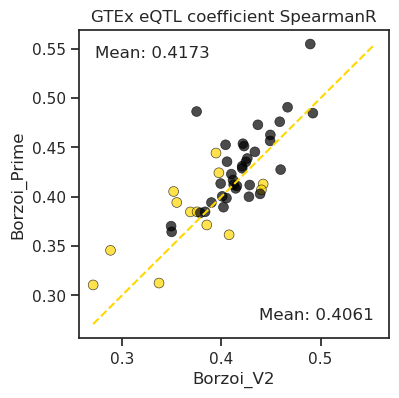

In [26]:
#Plot eQTL coefficient correlations (old vs new)

colors = np.array(['black'] * len(metrics_borzoi_df_old), dtype=object)

brain_index = np.nonzero(metrics_borzoi_df_old['tissue'].str.contains("Brain_").values)[0]
colors[brain_index] = 'gold'

plt.figure(figsize=(4,4))
plt.title('GTEx eQTL coefficient SpearmanR')
sns.scatterplot(x=metrics_borzoi_df_old.spearmanr.values,
                y=metrics_borzoi_df_new.spearmanr.values,
                c=colors, linewidth=0.5, edgecolor='black', alpha=0.7, s=50)
ax = plt.gca()

ax.text(0.95, 0.05, 'Mean: %.4f' % metrics_borzoi_df_old.spearmanr.mean(), 
                horizontalalignment='right', verticalalignment='bottom',
                transform=ax.transAxes)
ax.text(0.05, 0.95, 'Mean: %.4f' % metrics_borzoi_df_new.spearmanr.mean(), 
                horizontalalignment='left', verticalalignment='top',
                transform=ax.transAxes)

vmin = min(metrics_borzoi_df_old.spearmanr.min(), metrics_borzoi_df_new.spearmanr.min())
vmax = max(metrics_borzoi_df_old.spearmanr.max(), metrics_borzoi_df_new.spearmanr.max())
ax.plot([vmin,vmax], [vmin,vmax], linestyle='--', c='gold')

ax.set_xlabel('Borzoi_V2')
ax.set_ylabel('Borzoi_Prime')

plt.savefig('eqtl_coef_scatter_prime_sed.pdf')


In [21]:
#Print list of Spearman correlation metrics (old)
metrics_borzoi_df_old


,tissue,method,spearmanr
0,Adipose_Subcutaneous,Borzoi_V2,0.402180
2,Adipose_Visceral_Omentum,Borzoi_V2,0.428573
4,Adrenal_Gland,Borzoi_V2,0.458816
6,Artery_Aorta,Borzoi_V2,0.414446
8,Artery_Coronary,Borzoi_V2,0.399367
10,Artery_Tibial,Borzoi_V2,0.412484
12,Brain_Amygdala,Borzoi_V2,0.352018
14,Brain_Anterior_cingulate_cortex_BA24,Borzoi_V2,0.442110
16,Brain_Caudate_basal_ganglia,Borzoi_V2,0.385378
18,Brain_Cerebellar_Hemisphere,Borzoi_V2,0.337328


In [22]:
#Print list of Spearman correlation metrics (new)
metrics_borzoi_df_new


,tissue,method,spearmanr
1,Adipose_Subcutaneous,Borzoi_Prime,0.389418
3,Adipose_Visceral_Omentum,Borzoi_Prime,0.411880
5,Adrenal_Gland,Borzoi_Prime,0.475969
7,Artery_Aorta,Borzoi_Prime,0.408480
9,Artery_Coronary,Borzoi_Prime,0.413355
11,Artery_Tibial,Borzoi_Prime,0.412190
13,Brain_Amygdala,Borzoi_Prime,0.405327
15,Brain_Anterior_cingulate_cortex_BA24,Borzoi_Prime,0.412865
17,Brain_Caudate_basal_ganglia,Borzoi_Prime,0.371418
19,Brain_Cerebellar_Hemisphere,Borzoi_Prime,0.312561
